In [112]:
import pandas as pd
import numpy
import csv
from matplotlib.colors import LinearSegmentedColormap

In [58]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
aave_csv = pd.read_csv("/kaggle/input/datasets-aae-sae/aave_samples.csv",header=None)
sae_csv = pd.read_csv("/kaggle/input/datasets-aae-sae/sae_samples.csv",header=None)

In [3]:
aave_csv.rename(columns = {0:'AAVE'},inplace = True)

In [4]:
sae_csv.rename(columns = {0:'SAE'},inplace = True)

In [5]:
merged_df = pd.concat([aave_csv, sae_csv], axis=1)


In [6]:
merged_df

,AAVE,SAE
0,Sooo Manti Te'o was having a online/phone rela...,Manti Te'o was having a relationship via telep...
1,this lil girl aint going to win im the king of...,The little girl is not going to win because i ...
2,He up stairs rights now and I'm down here gett...,He is upstairs rights now and I'm down here ge...
3,Shit I Am Who Am..Fresh up out of Apologize..I...,"Shit, I am who I am. I'm done apologizing. I'm..."
4,It's very rare that I get what I want. Now tha...,"It is very rare that I get what I want, but no..."
...,...,...
2014,At least I'm happy with knowing I'm always coo...,At least I'm happy with knowing I'm always coo...
2015,I love when you ad lip. If that's what you cal...,"I love when you ad-lib, if that's what you cal..."
2016,ISO a nice place to do karaoke or DJ music tha...,In search of a nice place to do karaoke or dis...
2017,"Must be an establishment with a ""Grown Folks"" ...",I am looking for an establishment that has a \...


In [7]:
#!pip install transformers torch pandas datasets


In [8]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Split the dataset into training and testing
train_df, test_df = train_test_split(merged_df, test_size=0.1)  # Adjust the test_size as needed

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('facebook/mbart-large-en-ro')

'''def tokenize_function(examples):
    # Tokenize both the AAE (input) and SAE (target) sentences
    model_inputs = tokenizer(examples["AAVE"], max_length=128, padding="max_length", truncation=True)
    # Prepare the decoder_input_ids
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["SAE"], max_length=128, padding="max_length", truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs
'''

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('facebook/mbart-large-en-ro')

def tokenize_function(examples):
    # Tokenize both the AAE (input) and SAE (target) sentences.
    model_inputs = tokenizer(examples["AAVE"], max_length=128, padding="max_length", truncation=True)

    # Tokenize the labels without using return_tensors="pt" to keep them as lists
    labels = tokenizer(examples["SAE"], max_length=128, padding="max_length", truncation=True)
    
    # Update model_inputs to include labels; ensure labels are lists
    model_inputs["labels"] = labels["input_ids"]
    
    return model_inputs


# Mapping the tokenization function over the datasets.
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)


config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [10]:
#### Inspect the first few examples from the tokenized training dataset
for i in range(5):
    print("AAVE:", tokenizer.decode(tokenized_train_dataset[i]['input_ids'], skip_special_tokens=True))
    print("SAE:", tokenizer.decode(tokenized_train_dataset[i]['labels'], skip_special_tokens=True), '\n')


2024-03-13 22:38:12.236790: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 22:38:12.236913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 22:38:12.523468: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AAVE: i cant tell u much right now homie bc Kobe & KD playin, but u gotta be encouraged and determined.Great success doesnt come easy.
SAE: I can't tell you much right now, homie, because Kobe and KD are playing, but you have to be encouraged and determined.Great success doesn't come easy 

AAVE: I Know I'm Not Ugly But DAMN! Can a Bitch Get SomeType Of Affection Or Nah?
SAE: I know I'm not ugly but damn! Can a bitch get some type of affection or no? 

AAVE: I need to try and work these too jobs out; well ifI get the other one
SAE: I need to figure out how to manage these two jobs. Well, ifI get the other one 

AAVE: My Principal and half of my co workers are leaving work early to go to the Ravens Parade...?? How is thatsuppose to work yo? Lol
SAE: My principal and half of my co-workers are leaving work early to go to the Ravens Parade. Hey, how is thatsupposed to work? Ha, ha 

AAVE: Literally tho,Leonard is the only player who looks like he can keep up, theball movement is looking AO

In [11]:
print(f"Training Set Size: {len(train_df)}, Test Set Size: {len(test_df)}")


Training Set Size: 1817, Test Set Size: 202


In [12]:
from transformers import AutoModelForSeq2SeqLM, TrainingArguments, Trainer

model = AutoModelForSeq2SeqLM.from_pretrained('facebook/mbart-large-en-ro')

training_args = TrainingArguments(
    output_dir='./results',          # directory for saving models and checkpoints
    num_train_epochs=5,              # number of training epochs, adjust as needed
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=8,    # batch size for evaluation
    warmup_steps=500,                # number of warmup steps
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
)
trainer.train()
trainer.evaluate(eval_dataset=tokenized_test_dataset)

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
500,2.475900


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1024, 'num_beams': 5, 'forced_eos_token_id': 2}
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.37710049748420715,
 'eval_runtime': 8.8255,
 'eval_samples_per_second': 22.888,
 'eval_steps_per_second': 1.473,
 'epoch': 5.0}

In [13]:
def translate_aae_to_sae(sentence, model, tokenizer, device='cuda'):
    # Move the model to the specified device
    model.to(device)

    # Tokenize the input sentence
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Move the input tensors to the same device as the model
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Generate translation output
    output_sequences = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=256,
    )

    # Decode the output
    translated_sentence = tokenizer.decode(output_sequences[0], skip_special_tokens=True)
    return translated_sentence


# Example usage
aae_sentence = "Boy you can say anything you wanna I don't give a shit, noone else can have ya"
sae_translation = translate_aae_to_sae(aae_sentence, model, tokenizer)
print(f"AAE: {aae_sentence}\nSAE: {sae_translation}")

aae_sentence = "Where you been"
sae_translation = translate_aae_to_sae(aae_sentence, model, tokenizer)
print(f"AAE: {aae_sentence}\nSAE: {sae_translation}")

aae_sentence = "Wassup, nigga?"
sae_translation = translate_aae_to_sae(aae_sentence, model, tokenizer)
print(f"AAE: {aae_sentence}\nSAE: {sae_translation}")

AAE: Boy you can say anything you wanna I don't give a shit, noone else can have ya
SAE: You can say anything you want to, I don't give a shit. Noone else can have you
AAE: Where you been
SAE: Where have you been
AAE: Wassup, nigga?
SAE: What's up, man?


In [14]:
tweet_df = pd.read_csv("/kaggle/input/twitter-final-data/Preprocessed_Data_Final.csv")

In [15]:
def apply_translation(row):
    if row['AAVE'] == 1:
        return translate_aae_to_sae(row['cleaned_tweet'], model, tokenizer)
    else:
        return row['cleaned_tweet']

# Apply the function row-wise
tweet_df['SAE_tweet'] = tweet_df.apply(apply_translation, axis=1)


In [16]:
tweet_df.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
AAVE_hate_speech      0
AAVE                  0
new_class             0
cleaned_tweet         1
SAE_tweet             1
dtype: int64

In [17]:
tweet_df.dropna(inplace = True)

In [18]:
tweet_df.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
AAVE_hate_speech      0
AAVE                  0
new_class             0
cleaned_tweet         0
SAE_tweet             0
dtype: int64

### Running Roberta Model to detect hate speech

In [19]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem.porter import *
import string
import re
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [20]:
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          Trainer, 
                          TrainingArguments)

tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [21]:
def tokenize_data(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors="pt")


In [22]:
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [23]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## Running code for original data on new_class and cleaned_tweet

In [24]:
from sklearn.model_selection import KFold

In [50]:
num_splits = 5  # For k-fold cross-validation
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.239500
1000,0.165400
1500,0.137200
2000,0.119500
2500,0.093600
3000,0.068400


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.238200
1000,0.166300
1500,0.139500
2000,0.121100
2500,0.094900
3000,0.065600


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.237400
1000,0.171100
1500,0.146400
2000,0.131700
2500,0.109100
3000,0.079000


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.235300
1000,0.169000
1500,0.145400
2000,0.123600
2500,0.101500
3000,0.075100


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.241600
1000,0.163300
1500,0.142400
2000,0.119700
2500,0.083300
3000,0.063900


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.


Average Accuracy: 0.9394747858215032
Average False Positive Rate: 0.02758919410776765
Average False Negative Rate: 0.5990489232919662


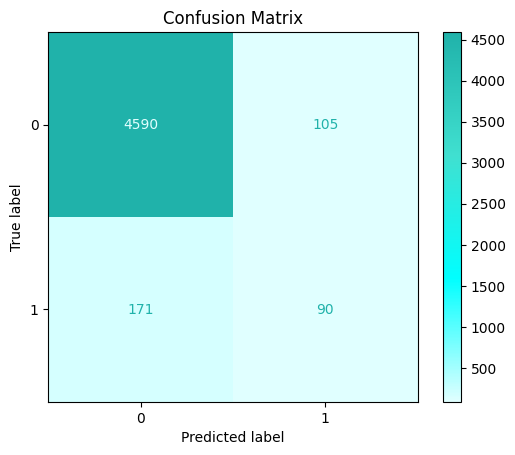

In [42]:
X = tweet_df['cleaned_tweet']
y = tweet_df['new_class']

accuracies = []
fprs = []  # To store False Positive Rates
fnrs = [] 

for train_index, test_index in kf.split(X):
    # Splitting data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Tokenization
    train_encodings = tokenize_data(X_train)
    test_encodings = tokenize_data(X_test)
    
    # Convert labels to tensors
    y_train_tensor = torch.tensor(y_train.values)
    y_test_tensor = torch.tensor(y_test.values)
    
    # Creating datasets
    train_dataset = TextDataset(train_encodings, y_train_tensor)
    test_dataset = TextDataset(test_encodings, y_test_tensor)
    
    # Initialize the model for each split
    model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2, return_dict=True)
    
    training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing log
    )
    
    # Trainer
    trainer = Trainer(
        model=model, 
        args=training_args,  # Make sure training_args is defined as before
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )
    
    # Training
    trainer.train()
    # Evaluation
    result = trainer.evaluate()
    
    # Prediction
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    
    # Metrics calculation
    true_labels = predictions.label_ids
    accuracy = accuracy_score(true_labels, preds)
    accuracies.append(accuracy)
    
    cm = confusion_matrix(true_labels, preds)
    FP = cm[0][1]
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FPR = FP / float(FP + TN)
    FNR = FN / float(FN + TP)
    
    fprs.append(FPR)
    fnrs.append(FNR)

# Output average metrics across folds
print(f"Average Accuracy: {np.mean(accuracies)}")
print(f"Average False Positive Rate: {np.mean(fprs)}")
print(f"Average False Negative Rate: {np.mean(fnrs)}")


cyan_shades = ["#E0FFFF", "#00FFFF", "#40E0D0", "#20B2AA"]
cmap_name = "custom_cyan_shades"
custom_cyan_cmap = LinearSegmentedColormap.from_list(cmap_name, cyan_shades)

cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = custom_cyan_cmap)
plt.title('Confusion Matrix')
plt.show()


## Running code for original data on original_class and SAE_tweet

In [ ]:
X = tweet_df['SAE_tweet']
y = tweet_df['new_class']

accuracies = []
fprs = []  # To store False Positive Rates
fnrs = [] 

for train_index, test_index in kf.split(X):
    # Splitting data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Tokenization
    train_encodings = tokenize_data(X_train)
    test_encodings = tokenize_data(X_test)
    
    # Convert labels to tensors
    y_train_tensor = torch.tensor(y_train.values)
    y_test_tensor = torch.tensor(y_test.values)
    
    # Creating datasets
    train_dataset = TextDataset(train_encodings, y_train_tensor)
    test_dataset = TextDataset(test_encodings, y_test_tensor)
    
    # Initialize the model for each split
    model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2, return_dict=True)
    
    training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing log
    )
    
    # Trainer
    trainer = Trainer(
        model=model, 
        args=training_args,  # Make sure training_args is defined as before
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )
    
    # Training
    trainer.train()
    # Evaluation
    result = trainer.evaluate()
    
    # Prediction
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    
    # Metrics calculation
    true_labels = predictions.label_ids
    accuracy = accuracy_score(true_labels, preds)
    accuracies.append(accuracy)
    
    cm = confusion_matrix(true_labels, preds)
    FP = cm[0][1]
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FPR = FP / float(FP + TN)
    FNR = FN / float(FN + TP)
    
    fprs.append(FPR)
    fnrs.append(FNR)

# Output average metrics across folds
print(f"Average Accuracy: {np.mean(accuracies)}")
print(f"Average False Positive Rate: {np.mean(fprs)}")
print(f"Average False Negative Rate: {np.mean(fnrs)}")


cyan_shades = ["#E0FFFF", "#00FFFF", "#40E0D0", "#20B2AA"]
cmap_name = "custom_cyan_shades"
custom_cyan_cmap = LinearSegmentedColormap.from_list(cmap_name, cyan_shades)

cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = custom_cyan_cmap)
plt.title('Confusion Matrix')
plt.show()


## Running code for original data on updated_class and SAE_tweet

In [93]:
def update_class_after_debias(row):
    if row['AAVE'] == 1:
        if row['AAVE_hate_speech'] == 1:
            return 1
        else:
            return row['new_class']
    else:
        return row['new_class']

In [94]:
tweet_df['updated_class'] = tweet_df.apply(update_class_after_debias, axis=1)

In [ ]:
X = tweet_df['SAE_tweet']
y = tweet_df['updated_class']

accuracies = []
fprs = []  # To store False Positive Rates
fnrs = [] 

for train_index, test_index in kf.split(X):
    # Splitting data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Tokenization
    train_encodings = tokenize_data(X_train)
    test_encodings = tokenize_data(X_test)
    
    # Convert labels to tensors
    y_train_tensor = torch.tensor(y_train.values)
    y_test_tensor = torch.tensor(y_test.values)
    
    # Creating datasets
    train_dataset = TextDataset(train_encodings, y_train_tensor)
    test_dataset = TextDataset(test_encodings, y_test_tensor)
    
    # Initialize the model for each split
    model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=2, return_dict=True)
    
    training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing log
    )
    
    # Trainer
    trainer = Trainer(
        model=model, 
        args=training_args,  # Make sure training_args is defined as before
        train_dataset=train_dataset,
        eval_dataset=test_dataset
    )
    
    # Training
    trainer.train()
    # Evaluation
    result = trainer.evaluate()
    
    # Prediction
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=-1)
    
    # Metrics calculation
    true_labels = predictions.label_ids
    accuracy = accuracy_score(true_labels, preds)
    accuracies.append(accuracy)
    
    cm = confusion_matrix(true_labels, preds)
    FP = cm[0][1]
    TN = cm[0][0]
    FN = cm[1][0]
    TP = cm[1][1]
    FPR = FP / float(FP + TN)
    FNR = FN / float(FN + TP)
    
    fprs.append(FPR)
    fnrs.append(FNR)

# Output average metrics across folds
print(f"Average Accuracy: {np.mean(accuracies)}")
print(f"Average False Positive Rate: {np.mean(fprs)}")
print(f"Average False Negative Rate: {np.mean(fnrs)}")


cyan_shades = ["#E0FFFF", "#00FFFF", "#40E0D0", "#20B2AA"]
cmap_name = "custom_cyan_shades"
custom_cyan_cmap = LinearSegmentedColormap.from_list(cmap_name, cyan_shades)

cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = custom_cyan_cmap)
plt.title('Confusion Matrix')
plt.show()


 ### Running it for just for AAVE cases on new_class and cleaned_tweet

In [ ]:
Average Accuracy: 0.9375553250345782
Average False Positive Rate: 0.021637180911517194
Average False Negative Rate: 0.5061206535400083

# Running model for AAVE tweets

### Updated_class AND SAE transalated tweet for AAVE samples

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


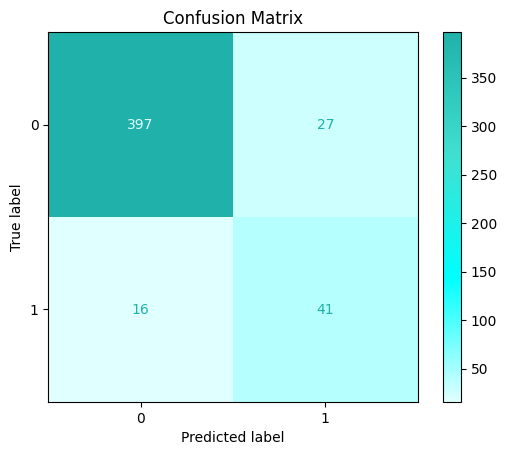

Accuracy: 0.9106029106029107
False Positive Rate: 0.06367924528301887
False Negative Rate: 0.2807017543859649


In [104]:
X_train,X_test, y_train, y_test = train_test_split(tweet_df[tweet_df['AAVE']==1],tweet_df[tweet_df['AAVE']==1]['updated_class'], test_size=0.4)
train_encodings = tokenize_data(X_train['SAE_tweet'])
test_encodings = tokenize_data(X_test['SAE_tweet'])
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)


train_dataset = TextDataset(train_encodings, y_train_tensor)
test_dataset = TextDataset(test_encodings, y_test_tensor)

num_labels = 2  # Adjust based on your task
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=num_labels)


training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing log
)
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
# We are going to get multiple loss values on each training step here
trainer.evaluate()

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

true_labels = predictions.label_ids

cm = confusion_matrix(true_labels, preds)

cyan_shades = ["#E0FFFF", "#00FFFF", "#40E0D0", "#20B2AA"]
cmap_name = "custom_cyan_shades"
custom_cyan_cmap = LinearSegmentedColormap.from_list(cmap_name, cyan_shades)

cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = custom_cyan_cmap)
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(true_labels, preds)
print(f"Accuracy: {accuracy}")

# Calculate False Positive Rate from Confusion Matrix
FP = cm[0][1]  # False Positives are the off-diagonal elements in the first row
TN = cm[0][0]  # True Negatives are the diagonal element in the first row
FN = cm[1][0]
TP = cm[1][1]
FPR = FP / float(FP + TN)  # FPR = FP / (FP + TN)
FNR = FN / float(FN + TP)
print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")



### original_class AND SAE translated tweet for AAVE samples

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


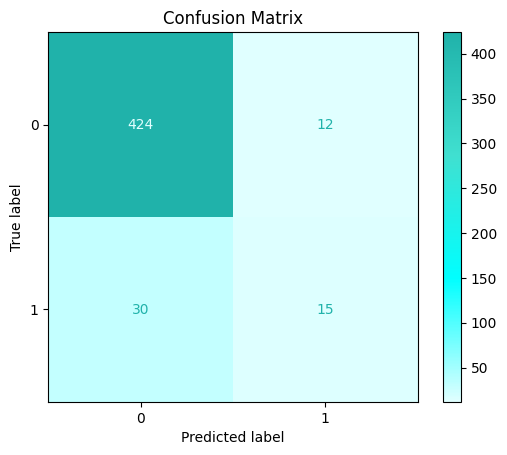

Accuracy: 0.9126819126819127
False Positive Rate: 0.027522935779816515
False Negative Rate: 0.6666666666666666


In [105]:
X_train,X_test, y_train, y_test = train_test_split(tweet_df[tweet_df['AAVE']==1],tweet_df[tweet_df['AAVE']==1]['new_class'], test_size=0.4)
train_encodings = tokenize_data(X_train['SAE_tweet'])
test_encodings = tokenize_data(X_test['SAE_tweet'])
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)


train_dataset = TextDataset(train_encodings, y_train_tensor)
test_dataset = TextDataset(test_encodings, y_test_tensor)

num_labels = 2  # Adjust based on your task
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=num_labels)


training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing log
)
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
# We are going to get multiple loss values on each training step here
trainer.evaluate()

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

true_labels = predictions.label_ids

cm = confusion_matrix(true_labels, preds)

cyan_shades = ["#E0FFFF", "#00FFFF", "#40E0D0", "#20B2AA"]
cmap_name = "custom_cyan_shades"
custom_cyan_cmap = LinearSegmentedColormap.from_list(cmap_name, cyan_shades)

cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = custom_cyan_cmap)
plt.title('Confusion Matrix for ')
plt.show()

accuracy = accuracy_score(true_labels, preds)
print(f"Accuracy: {accuracy}")

# Calculate False Positive Rate from Confusion Matrix
FP = cm[0][1]  # False Positives are the off-diagonal elements in the first row
TN = cm[0][0]  # True Negatives are the diagonal element in the first row
FN = cm[1][0]
TP = cm[1][1]
FPR = FP / float(FP + TN)  # FPR = FP / (FP + TN)
FNR = FN / float(FN + TP)
print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")



## cleaned_tweet and updated_class for AAVE samples

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


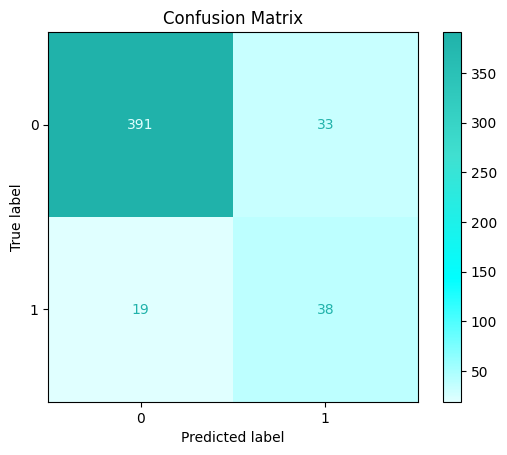

Accuracy: 0.8918918918918919
False Positive Rate: 0.07783018867924528
False Negative Rate: 0.3333333333333333


In [106]:
X_train,X_test, y_train, y_test = train_test_split(tweet_df[tweet_df['AAVE']==1],tweet_df[tweet_df['AAVE']==1]['updated_class'], test_size=0.4)
train_encodings = tokenize_data(X_train['cleaned_tweet'])
test_encodings = tokenize_data(X_test['cleaned_tweet'])
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)


train_dataset = TextDataset(train_encodings, y_train_tensor)
test_dataset = TextDataset(test_encodings, y_test_tensor)

num_labels = 2  # Adjust based on your task
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=num_labels)


training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing log
)
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
# We are going to get multiple loss values on each training step here
trainer.evaluate()

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

true_labels = predictions.label_ids

cm = confusion_matrix(true_labels, preds)

cyan_shades = ["#E0FFFF", "#00FFFF", "#40E0D0", "#20B2AA"]
cmap_name = "custom_cyan_shades"
custom_cyan_cmap = LinearSegmentedColormap.from_list(cmap_name, cyan_shades)

cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = custom_cyan_cmap)
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(true_labels, preds)
print(f"Accuracy: {accuracy}")

# Calculate False Positive Rate from Confusion Matrix
FP = cm[0][1]  # False Positives are the off-diagonal elements in the first row
TN = cm[0][0]  # True Negatives are the diagonal element in the first row
FN = cm[1][0]
TP = cm[1][1]
FPR = FP / float(FP + TN)  # FPR = FP / (FP + TN)
FNR = FN / float(FN + TP)
print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")



### cleaned_tweet and original_class for AAVE (Baseline Approach)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


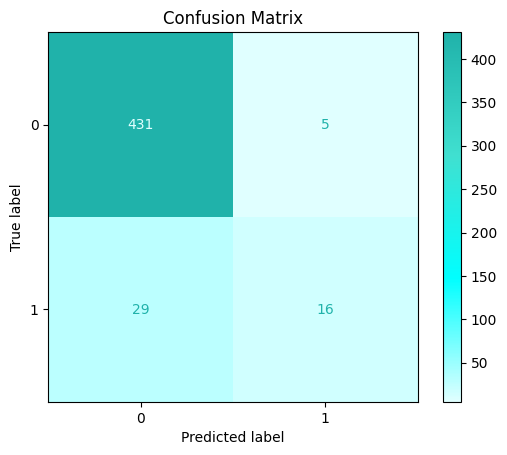

Accuracy: 0.9293139293139293
False Positive Rate: 0.011467889908256881
False Negative Rate: 0.6444444444444445


In [107]:
X_train,X_test, y_train, y_test = train_test_split(tweet_df[tweet_df['AAVE']==1],tweet_df[tweet_df['AAVE']==1]['new_class'], test_size=0.4)
train_encodings = tokenize_data(X_train['cleaned_tweet'])
test_encodings = tokenize_data(X_test['cleaned_tweet'])
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)


train_dataset = TextDataset(train_encodings, y_train_tensor)
test_dataset = TextDataset(test_encodings, y_test_tensor)

num_labels = 2  # Adjust based on your task
model = AutoModelForSequenceClassification.from_pretrained("distilroberta-base", num_labels=num_labels)


training_args = TrainingArguments(
    output_dir='./results',          # output directory for model predictions and checkpoints
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing log
)
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()
# We are going to get multiple loss values on each training step here
trainer.evaluate()

predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

true_labels = predictions.label_ids

cm = confusion_matrix(true_labels, preds)

cyan_shades = ["#E0FFFF", "#00FFFF", "#40E0D0", "#20B2AA"]
cmap_name = "custom_cyan_shades"
custom_cyan_cmap = LinearSegmentedColormap.from_list(cmap_name, cyan_shades)

cm = confusion_matrix(true_labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap = custom_cyan_cmap)
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(true_labels, preds)
print(f"Accuracy: {accuracy}")

# Calculate False Positive Rate from Confusion Matrix
FP = cm[0][1]  # False Positives are the off-diagonal elements in the first row
TN = cm[0][0]  # True Negatives are the diagonal element in the first row
FN = cm[1][0]
TP = cm[1][1]
FPR = FP / float(FP + TN)  # FPR = FP / (FP + TN)
FNR = FN / float(FN + TP)
print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")

